### 文本抄袭自动检测分析:
#### 如果你是某新闻单位工作人员（这里假设source=新华社），为了防止其他媒体抄袭你的文章，你打算做一个抄袭自动检测分析的工具
#### 1）定义可能抄袭的文章来源
#### 2）与原文对比定位抄袭的地方
#### 原始数据：sqlResult.csv，共计89611篇
#### 从数据库导出的文章，字段包括：id, author, source, content, feature, title, url
#### 常用中文停用词：chinese_stopwords.txt

In [1]:
import pandas as pd
import jieba
import matplotlib.pyplot as plt

In [2]:
# 数据读取
news = pd.read_csv('sqlResult.csv', encoding='gb18030')
news.shape

(89611, 7)

In [3]:
# 去除source 和content 相关的缺失值
news.dropna(subset=['content','source'], axis=0, inplace=True)
news.shape

(87052, 7)

In [4]:
# 停用词列表
stopwords = open('chinese_stopwords.txt', mode='r', encoding='utf-8').read() 
stopwords_list = stopwords.split('\n')

In [5]:
def split_word(text):
    '''
    输入text:str。每一条新闻报道
    输出result:str。分词后的结果
    1. 先将初级的' ' '\n' '\r'去掉
    2. 再做jieba分词
    3. 利用停用词筛选
    '''
    text = text.replace(' ', '').replace('\\n', '').replace('\n', '').replace('\r', '')
    result = ' '.join(str(word) for word in jieba.lcut(text) if str(word) not in stopwords_list)
    return result

In [6]:
# 对全量样本进行分词
corpus = list(map(split_word, news.content))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Jarvis\AppData\Local\Temp\jieba.cache
Loading model cost 0.634 seconds.
Prefix dict has been built successfully.


In [7]:
# TFIDF
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
countvectorizer = CountVectorizer(encoding='gb18030', min_df=0.015)
tfidftransformer = TfidfTransformer()
countvector = countvectorizer.fit_transform(corpus)
tfidf = tfidftransformer.fit_transform(countvector)

In [8]:
# 新华社label
label = list(map(lambda source: 1 if '新华社' in str(source) else 0, news.source))
len(label)

87052

#### 利用分类完成抄袭检查

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

In [10]:
# 数据集切分
x_train, x_test, y_train, y_test = train_test_split(tfidf.toarray(), label, test_size=0.3)

In [11]:
def CART():
    model = DecisionTreeClassifier()
    model.fit(x_train, y_train)
    y_pred  = model.predict(x_test)
    print('准确率：', accuracy_score(y_test, y_pred))
    print('精确率：', precision_score(y_test, y_pred))
    print('召回率：', recall_score(y_test, y_pred))
    return model

In [12]:
# 模型训练
model = CART()

准确率： 0.9854495328534232
精确率： 0.9906261875606975
召回率： 0.9933104703840129


In [13]:
# 全量分类
prediction = model.predict(tfidf.toarray())

In [14]:
# 对比标签与预测值
compare_news_df = pd.DataFrame({'label':label,'prediction':prediction})

In [15]:
# 新华社文章的index
xinhuashe_news_index = compare_news_df[compare_news_df.label==1].index
print('新华社文章数量：',len(xinhuashe_news_index))

新华社文章数量： 78674


In [16]:
# 抄袭文章的index，分类结果为1，标签为0的文章为抄袭
copy_news_index = compare_news_df[(compare_news_df['label']==0) & (compare_news_df['prediction']==1)].index
print('抄袭文章数量：',len(copy_news_index))

抄袭文章数量： 317


#### 利用聚类完成抄袭检测

In [17]:
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans

# 由于KMeans聚类计算的是欧氏距离，因此需要normalize对tfidf得出来的向量做转换（余弦距离-->欧氏距离）
norm = Normalizer()
tfidf_ = norm.fit_transform(tfidf.toarray())

# 利用手肘法选择超参数K
inertias = []
for k in range(1,20):
    kmeans = KMeans(n_clusters=k)
    k_label  = kmeans.fit_predict(tfidf_)
    inertias.append(kmeans.inertia_)

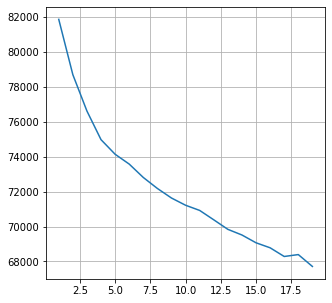

In [19]:
# 绘制 K-inertias 曲线
x = range(1,20)
y = inertias
plt.figure(figsize=(5,5))
plt.grid()
plt.axis('on')
plt.plot(x,y)
plt.show()

In [20]:
# 可以看到 K>=4后 kmeans.inertia_的变化幅度逐渐下降
kmeans = KMeans(n_clusters=4)
k_label  = kmeans.fit_predict(tfidf_)

In [21]:
# id到class的映射{1:class???, 2:class???, ..., 87054:class???}
id_class = {id:class_ for id, class_ in enumerate(k_label)}              

# class到id的映射，这里只考虑新华社的id.
from collections import defaultdict
class_id = defaultdict(set)

for index, class_ in id_class.items():                                    
    # 只统计新华社发布的class_id
    if index in xinhuashe_news_index.tolist():
        class_id[class_].add(index)     

In [22]:
# 查看每个类别中，新华社的文章数
xinhuashe_class_count = defaultdict(set)
for class_, ids in class_id.items():
    xinhuashe_class_count[class_].add(len(ids)) 
print('每个类中包含新华社的文章：',sorted(xinhuashe_class_count.items(), key=lambda x: x[0]))

每个类中包含新华社的文章： [(0, {46928}), (1, {9365}), (2, {7920}), (3, {14461})]


In [23]:
from sklearn.metrics.pairwise import cosine_similarity
# 根据相似度查找相似的文章
def find_similar_text(cpindex, N=10):
    # 将cpindex的文章在其所属的类别C中，与所有新华社的文章做相似度分析
    dist_dict = {i: cosine_similarity(tfidf[cpindex], tfidf[i]) for i in class_id[id_class[cpindex]]}       
    # TopN排序
    return sorted(dist_dict.items(), key=lambda x:-x[1][0])[:N]                             

In [24]:
cpindex = 3352

assert cpindex not in xinhuashe_news_index, '这篇文章来自新华社'

similar_list = find_similar_text(cpindex)
print('相似度排序：',similar_list)

相似度排序： [(3134, array([[0.96849062]])), (63509, array([[0.94643337]])), (29439, array([[0.94283553]])), (3218, array([[0.87622788]])), (29613, array([[0.86938324]])), (29886, array([[0.8617495]])), (29775, array([[0.853973]])), (64044, array([[0.85277972]])), (63972, array([[0.73656506]])), (63973, array([[0.73656506]]))]


In [25]:
print('怀疑抄袭：\n', news.iloc[cpindex].content)
# 找一篇相似的文章
similar2 = similar_list[0][0]
print('\n')
print('相似的原文：\n', news.iloc[similar2].content)

怀疑抄袭：
 　　中国5月份56座城市新建商品住宅价格环比上涨，4月份为58座上涨。5月份15个一线和热点二线城市房地产市场基本稳定，5月份房地产调控政策效果继续显现。
　　统计局：15个一线和热点二线城市房价同比涨幅全部回落
　　国家统计局城市司高级统计师刘建伟解读5月份房价数据
　　5月份一二线城市房价平均涨幅继续回落
　　国家统计局今日发布了2017年5月份70个大中城市住宅销售价格统计数据。对此，国家统计局城市司高级统计师刘建伟进行了解读。
　　一、15个一线和热点二线城市新建商品住宅价格同比涨幅全部回落、9个城市环比下降或持平
　　5月份，因地制宜、因城施策的房地产调控政策效果继续显现，15个一线和热点二线城市房地产市场基本稳定。从同比看，15个城市新建商品住宅价格涨幅均比上月回落，回落幅度在0.5至6.4个百分点之间。从环比看，9个城市新建商品住宅价格下降或持平；5个城市涨幅在0.5%以内。
　　二、70个大中城市中一二线城市房价同比涨幅持续回落
　　5月份，70个城市中新建商品住宅和二手住宅价格同比涨幅比上月回落的城市分别有29和18个。其中，一二线城市同比涨幅回落尤其明显。据测算，一线城市新建商品住宅和二手住宅价格同比涨幅均连续8个月回落，5月份比4月份分别回落2.2和1.7个百分点；二线城市新建商品住宅和二手住宅价格同比涨幅分别连续6个月和4个月回落，5月份比4月份分别回落0.8和0.5个百分点。
　　三、70个大中城市中房价环比下降及涨幅回落城市个数均有所增加
　　5月份，70个城市中新建商品住宅价格环比下降的城市有9个，比上月增加1个；涨幅回落的城市有26个，比上月增加3个。二手住宅价格环比下降的城市有7个，比上月增加2个；涨幅回落的城市有30个，比上月增加8个。



相似的原文：
 　　国家统计局19日发布数据，5月份，15个一线和热点二线城市新建商品住宅价格同比涨幅全部回落，其中9个城市环比下降或持平。这9个价格环比下降或持平的城市为：北京、上海、南京、杭州、合肥、福州、郑州、深圳、成都。
　　“5月份，因地制宜、因城施策的房地产调控政策效果继续显现，15个一线和热点二线城市房地产市场基本稳定。”国家统计局城市司高级统计师刘建伟说，从同比看，15个城市新建商品住宅价格涨幅均比上月回落，回落幅度在0.5至6.4个百分点之间。从环比看，9个城